# Stacked Carton Dataset: Create train_df to fine-tune Florence-2 model

In the previous Colab notebook [0_SCD_download_explore.ipynb](https://github.com/aguille-vert/florence-2-scd/blob/main/notebooks/0_SCD_download_explore.ipynb) we downloaded and explored SCD. Now we are going to use some of the downloaded images to create dataset to fine-tune Florence-2 model  

* Original paper: [Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks](https://arxiv.org/abs/2311.06242)
* Huggingface blog post [Fine-tuning Florence-2 - Microsoft's Cutting-edge Vision Language Models](https://huggingface.co/blog/finetune-florence2)  
* [Jupyter Notebook for inference and visualization of Florence-2-large model](https://huggingface.co/microsoft/Florence-2-large/blob/main/sample_inference.ipynb)
* Roboflow NB [Fine-tuning Florence-2 on Object Detection Dataset](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-florence-2-on-detection-dataset.ipynb?ref=blog.roboflow.com)

Florence-2 is an advanced vision foundation model that uses a prompt-based approach to handle a wide range of vision and vision-language tasks. Florence-2 can interpret simple text prompts to perform tasks like captioning, object detection, and segmentation. It leverages our FLD-5B dataset, containing 5.4 billion annotations across 126 million images, to master multi-task learning. The model's sequence-to-sequence architecture enables it to excel in both zero-shot and fine-tuned settings, proving to be a competitive vision foundation model.  

When fine-tuning the model, Florence-2 processor shall be used to process images and bboxes into the prompt format expected by the model:

* CHECKPOINT = "microsoft/Florence-2-base-ft"
* REVISION = 'refs/pr/6'
* processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

* bbox format expected by the processor:  
(xmin, ymin, xmax, ymax)


# Setup

In [ ]:
!pip install jsonlines
from IPython.display import clear_output
clear_output()
import jsonlines

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import zipfile
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/0_Projects/drone-warehouse/'
os.chdir(path)

# Create train_df

## select images
there are 3 sub-sets of SCD images:
* OSCD
* LSCD
* LSCD occlusions

above subsets have train and val variations  
We are going to take a sample of 2000 images from LSCD images and split it into:
* train_df
* test_df
* val_df

## LSCD
bbox column contains bboxes in the format :
(x1,y1, width, height)  

Florence-2 processor expects bboxes in the format:  
(xmin, ymin, xmax,ymax)  

We need to provide bbxes in the format expected by the processor  

Florence-2 expects images size 640x640
we need to resize images and adjust bboxes accordingly

In [ ]:
zip_file_path = './images/LSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    lscd_filenames = zip_ref.namelist()

lscd_fn_df = pd.DataFrame(lscd_filenames,
                          columns = ['file_name'])
lscd_fn_df.shape

(7741, 1)

In [ ]:
file_name = 'annotations/instances_train2017.json'
zip_file_path = './images/LSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)


lscd_image_train_df = pd.DataFrame(json_data['images'])
lscd_annot_train_df = pd.DataFrame(json_data['annotations'])

lscd_image_train_df.shape, lscd_annot_train_df.shape

((6735, 4), (70838, 7))

In [ ]:
lscd_image_train_df.head()

,height,width,id,file_name
0,3680,2728,0,2850.jpg
1,2976,3968,1,6 (144).jpg
2,3809,2736,2,IMG_20191125_145411.jpg
3,5792,4344,3,y (18).jpg
4,3264,2001,4,2021.jpg


In [ ]:
lscd_annot_train_df

,id,image_id,category_id,segmentation,bbox,iscrowd,area
0,0,0,1,"[[90.82352941176464, 3184.3529411764703, 1467....","[90.82352941176464, 3125.529411764706, 1376.47...",0,663944.636678
1,1,0,1,"[[1467.2941176470586, 3125.529411764706, 2331....","[1467.2941176470586, 3096.1176470588234, 864.7...",0,391660.899654
2,2,0,1,"[[2331.9999999999995, 3096.1176470588234, 2727...","[2302.5882352941176, 3070.0, 424.4117647058824...",0,190835.501730
3,3,0,1,"[[967.2941176470586, 2684.3529411764703, 2320....","[961.411764705882, 2654.941176470588, 1370.588...",0,661107.266436
4,4,0,1,"[[20.235294117646845, 2696.1176470588234, 967....","[20.235294117646845, 2678.470588235294, 947.05...",0,467958.477509
...,...,...,...,...,...,...,...
70833,70833,6734,1,"[[1846.9655172413795, 1842.7586206896553, 2447...","[1805.586206896552, 1842.0, 641.4137931034479,...",0,453899.788347
70834,70834,6734,1,"[[1891.7931034482763, 935.8620689655173, 2447....","[1891.7931034482763, 1.0, 555.2068965517237, 9...",0,519041.868014
70835,70835,6734,1,"[[1871.1034482758623, 939.3103448275863, 1933....","[1129.7241379310349, 0.0, 803.2758620689651, 9...",0,771144.827586
70836,70836,6734,1,"[[1174.5517241379312, 963.4482758620691, 474.5...","[313.0, 0.0, 861.5517241379312, 980.6896551724...",0,844914.863258


we need to rename 'id' in lscd_image_train_df into 'image_id' since in annot_df 'id' refers to bboxes rather than images

In [ ]:
lscd_image_train_df.rename(columns={'id' : 'image_id'}, inplace=True)
lscd_image_train_df = lscd_image_train_df.merge(lscd_annot_train_df[['image_id',
                                                        'segmentation',
                                                                     'bbox']],
                    on='image_id')
lscd_image_train_df.shape

(70838, 6)

In [ ]:
lscd_image_train_df.image_id.nunique(), lscd_annot_train_df['id'].nunique()

(6733, 70838)

we have 6733 images and 70,838 annotated bboxes

### visualize image

In [ ]:
image_ids = list(lscd_image_train_df['image_id'].unique())
print(len(image_ids))

6733


this is an original image without segments:

5386
images/train2017/1 (77).jpg


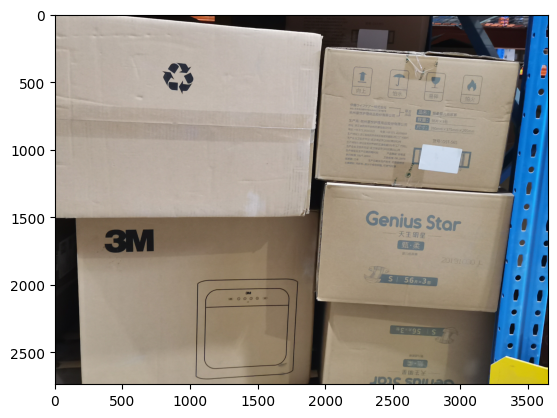

In [ ]:
from random import choice
n = choice(image_ids)
print(n)
# image_id = image_ids[n]
image_id = 2049
image_df = lscd_image_train_df.query("image_id==@image_id")

image_suffix = image_df.iloc[1,3]
img_fn = f"images/train2017/{image_suffix}"
print(img_fn)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(img_fn) as file:
    file_content = file.read()
    image = Image.open(BytesIO(file_content))
plt.imshow(image);

let's draw segments on the image

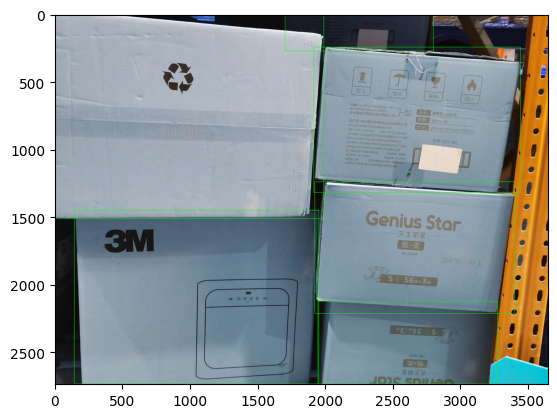

In [ ]:
numpy_image = np.array(image)
numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
bboxes = image_df['bbox'].apply(lambda x: [int(x[0]),
                                           int(x[1]),
                                           int(x[0]+x[2]),
                                           int(x[1]+x[3])]).tolist()
for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(numpy_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(numpy_image)

we can also use col. 'segments' to do the same; in many cases polygons will be closer to the truth compared to the bboxes

In [ ]:
def convert_to_polygon_array(coordinates_list):
    polygons = []
    for coordinates in coordinates_list:
        # Convert the list to a NumPy array and reshape it to separate x and y coordinates
        coordinates_array = np.array(coordinates).reshape(-1, 2)

        # Convert the coordinates to integers
        integer_array = coordinates_array.astype(np.int32)

        polygons.append(integer_array)

    return polygons



In [ ]:
segments = image_df['segmentation'].tolist()
print(len(segments))
polygons = convert_to_polygon_array(segments)
print(len(polygons))

6
6


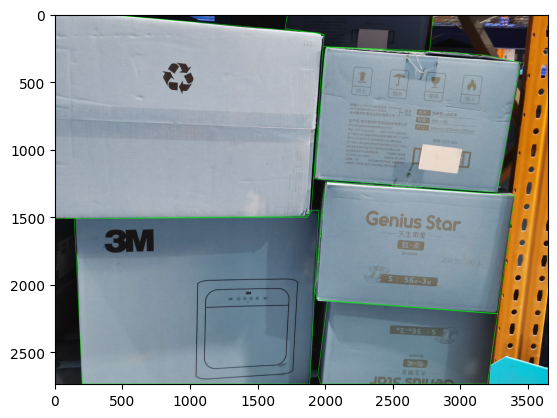

In [ ]:
numpy_image = np.array(image)
numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
for polygon in polygons:
        # Draw the polygon by connecting each point
        cv2.polylines(numpy_image, [polygon],
                      isClosed=True,
                      color=(0, 255, 0),
                      thickness=2)
plt.imshow(numpy_image);

### pre-processing
bboxes are less accurate than polygons, but they need only 4 coordinates, whereas polygons can include 6 and more coordinates. Since many images may contains dozens of segments, sequence of polygon coordinates may become very long.  

Therefore we will first create a dataset based on bboxes.  

We will convert COCO format (x1,y1, W, H) into (x1,y1, x2, y2) format

In [ ]:
df = lscd_image_train_df.query("file_name.str.contains('.jpg')").reset_index(drop=True)

df['file_path'] = df['file_name'].apply(lambda x: f"images/train2017/{x}")

df['zip_file_path'] = './images/LSCD.zip'

# in the original zip archive file names of images are not linked to image_ids
# we will create new names for images, which will include image_id
# when extracting and saving images in image folder we will use the new image names
df['output_image_fn'] = df.apply(lambda x:
                                 f"{x.zip_file_path.split('/')[-1].split('.')[0]}_{x.image_id}.jpg",
                                 axis=1)
# we will re-size images to a standard H, W
target_height, target_width = 768, 768
df['target_height'] = target_height
df['target_width'] = target_width

# convert bboxes into COCO format
df['bbox'] = df['bbox'].apply(lambda x:
                                          [int(x[0]),
                                           int(x[1]),
                                           int(x[0]+x[2]),
                                           int(x[1]+x[3])]
                                                     )
# we are going to re-size all images when extracting from zip archive;
# we need to resize bboxes accordingly

df['resized_bbox'] = df.apply(lambda x:
                            [int(x['bbox'][0]*x['target_width']/x['width']),
                              int(x['bbox'][1]*x['target_height']/x['height']),
                              int(x['bbox'][2]*x['target_width']/x['width']),
                              int(x['bbox'][3]*x['target_height']/x['height'])
                              ]
                                        , axis=1)

df.shape

(70838, 12)

In [ ]:
df

,height,width,image_id,file_name,segmentation,bbox,file_path,zip_file_path,output_image_fn,target_height,target_width,resized_bbox
0,3680,2728,0,2850.jpg,"[[90.82352941176464, 3184.3529411764703, 1467....","[90, 3125, 1467, 3607]",images/train2017/2850.jpg,./images/LSCD.zip,LSCD_0.jpg,768,768,"[25, 652, 412, 752]"
1,3680,2728,0,2850.jpg,"[[1467.2941176470586, 3125.529411764706, 2331....","[1467, 3096, 2331, 3549]",images/train2017/2850.jpg,./images/LSCD.zip,LSCD_0.jpg,768,768,"[412, 646, 656, 740]"
2,3680,2728,0,2850.jpg,"[[2331.9999999999995, 3096.1176470588234, 2727...","[2302, 3070, 2727, 3519]",images/train2017/2850.jpg,./images/LSCD.zip,LSCD_0.jpg,768,768,"[648, 640, 767, 734]"
3,3680,2728,0,2850.jpg,"[[967.2941176470586, 2684.3529411764703, 2320....","[961, 2654, 2331, 3137]",images/train2017/2850.jpg,./images/LSCD.zip,LSCD_0.jpg,768,768,"[270, 553, 656, 654]"
4,3680,2728,0,2850.jpg,"[[20.235294117646845, 2696.1176470588234, 967....","[20, 2678, 967, 3172]",images/train2017/2850.jpg,./images/LSCD.zip,LSCD_0.jpg,768,768,"[5, 558, 272, 661]"
...,...,...,...,...,...,...,...,...,...,...,...,...
70833,3264,2448,6734,4 (79).jpg,"[[1846.9655172413795, 1842.7586206896553, 2447...","[1805, 1842, 2447, 2549]",images/train2017/4 (79).jpg,./images/LSCD.zip,LSCD_6734.jpg,768,768,"[566, 433, 767, 599]"
70834,3264,2448,6734,4 (79).jpg,"[[1891.7931034482763, 935.8620689655173, 2447....","[1891, 1, 2447, 935]",images/train2017/4 (79).jpg,./images/LSCD.zip,LSCD_6734.jpg,768,768,"[593, 0, 767, 220]"
70835,3264,2448,6734,4 (79).jpg,"[[1871.1034482758623, 939.3103448275863, 1933....","[1129, 0, 1933, 960]",images/train2017/4 (79).jpg,./images/LSCD.zip,LSCD_6734.jpg,768,768,"[354, 0, 606, 225]"
70836,3264,2448,6734,4 (79).jpg,"[[1174.5517241379312, 963.4482758620691, 474.5...","[313, 0, 1174, 980]",images/train2017/4 (79).jpg,./images/LSCD.zip,LSCD_6734.jpg,768,768,"[98, 0, 368, 230]"


#### visualize resized image
let's make sure that we resized bboxes correctly

6620
LSCD_6620.jpg
ft-scd-coco-dataset/train/LSCD_6620.jpg


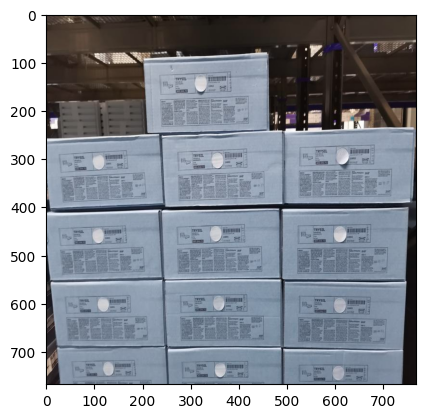

In [ ]:
image_df = train_annot_df.sample(1)
image_id = image_df.image_id.tolist()[0]
print(image_id)
image_fn = image_df.output_image_fn.tolist()[0]
print(image_fn)
image_directory_path = 'ft-scd-coco-dataset/train'
image_path = os.path.join(image_directory_path, image_fn)
print(image_path)
image = Image.open(image_path)
image = np.array(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
resized_image = cv2.resize(image, (target_width, target_height))
plt.imshow(resized_image)

In [ ]:
resized_bboxes = train_annot_df.query("image_id==@image_id")['resized_bbox'].tolist()
len(resized_bboxes)

12

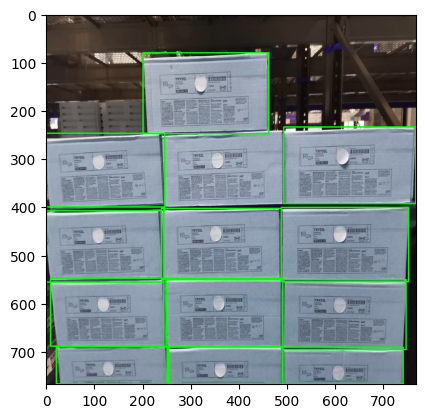

In [ ]:

for bbox in resized_bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(resized_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(resized_image)

### split images into train, val, test

In [ ]:
from random import choices
image_ids = df['image_id'].unique()

test_image_ids = choices(image_ids, k=150)
val_image_ids = choices(image_ids, k=150)
train_image_ids = [i for i in image_ids if i not in test_image_ids and i not in val_image_ids]

len(test_image_ids), len(val_image_ids), len(train_image_ids)

(150, 150, 6443)

In [ ]:
train_df = df.query("image_id==@train_image_ids")
test_df = df.query("image_id==@test_image_ids")
val_df = df.query("image_id==@val_image_ids")
print(train_df.shape, test_df.shape, val_df.shape)

(67494, 12) (1818, 12) (1568, 12)


# save images

#### save train_df images:

In [ ]:
# target_width = 768
# target_height = 768
image_directory_path = 'ft-scd-coco-dataset/train'

grouped = train_df.groupby('output_image_fn')
print(len(grouped))
failed = []
count = 0
for output_image_fn, gr in grouped:
  try:
    print(output_image_fn, gr.shape)


    # extract image and save it to image folder
    zip_file_path = gr.iloc[0,-3]
    image_file_path = gr.iloc[0,-4]
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      with zip_ref.open(image_file_path) as file:
          file_content = file.read()
          image = Image.open(BytesIO(file_content))
          resized_pil_image = image.resize((target_width, target_height),
                                          Image.Resampling.LANCZOS)
          resized_pil_image.save(f"{image_directory_path}/{output_image_fn}")
          # image_annotation = get_image_annotation(gr)
          # annotations.append(image_annotation)
  except:
    print(f"error with {output_image_fn}")
    failed.append(output_image_fn)

  count+=1
  print(count, len(failed))
  # break



In [ ]:
test_fns = os.listdir('ft-scd-coco-dataset/test')
test_fns = [i for i in test_fns if i.endswith('.jpg')]

val_fns = os.listdir('ft-scd-coco-dataset/val')
val_fns = [i for i in val_fns if i.endswith('.jpg')]

train_fns = os.listdir('ft-scd-coco-dataset/train')
train_fns = [i for i in train_fns if i.endswith('.jpg')]

len(test_fns), len(val_fns), len(train_fns)

(150, 150, 6432)

In [ ]:
train_annot_df = df.query("output_image_fn == @train_fns")
train_annot_df.shape, train_annot_df.image_id.nunique()

((67493, 12), 6432)

In [ ]:
categories = [
    {'id': 0, 'name': 'background', 'supercategory': 'None'},
    {'id': 1, 'name': 'boxes', 'supercategory': 'object'}]

images = []
for row in train_annot_df.drop_duplicates(subset=['image_id']).itertuples():
  image = {}
  image['id'] = row.image_id
  image['height'] = row.height
  image['width'] = row.width
  image['file_name'] = row.output_image_fn
  images.append(image)

annotations = []
for row in train_annot_df.itertuples():
  annotation = {}
  annotation['id'] = row[0]
  annotation['image_id'] = row.image_id
  annotation['category_id'] = 1
  annotation['bbox'] = row.resized_bbox
  annotation['area'] = row.resized_bbox[2]* row.resized_bbox[3]
  annotation['segmentation'] = []
  annotation['iscrowd'] = 0
  annotations.append(annotation)

train_annotations_coco = {}
train_annotations_coco['images'] = images
train_annotations_coco['categories'] = categories
train_annotations_coco['annotations'] = annotations

len(images), len(annotations)

(6432, 67493)

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/train'
file_name = 'annotations.coco.json'
file_name = os.path.join(image_directory_path, file_name)
with open(file_name, 'w') as f:
    json.dump(train_annotations_coco, f)

#### save test_df images

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/test'

grouped = test_df.groupby('output_image_fn')
print(len(grouped))
failed = []
count = 0
for output_image_fn, gr in grouped:
  try:
    print(output_image_fn, gr.shape)


    # extract image and save it to image folder
    zip_file_path = gr.iloc[0,-3]
    image_file_path = gr.iloc[0,-4]
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      with zip_ref.open(image_file_path) as file:
          file_content = file.read()
          image = Image.open(BytesIO(file_content))
          resized_pil_image = image.resize((target_width, target_height),
                                          Image.Resampling.LANCZOS)
          resized_pil_image.save(f"{image_directory_path}/{output_image_fn}")
          # image_annotation = get_image_annotation(gr)
          # annotations.append(image_annotation)
  except:
    print(f"error with {output_image_fn}")
    failed.append(output_image_fn)

  count+=1
  print(count, len(annotations), len(failed))
  # break

In [ ]:
test_annot_df = df.query("output_image_fn == @test_fns")
test_annot_df.shape, test_annot_df.image_id.nunique()

((1700, 12), 150)

In [ ]:
categories = [
    {'id': 0, 'name': 'background', 'supercategory': 'None'},
    {'id': 1, 'name': 'boxes', 'supercategory': 'object'}]

images = []
for row in test_annot_df.drop_duplicates(subset=['image_id']).itertuples():
  image = {}
  image['id'] = row.image_id
  image['height'] = row.height
  image['width'] = row.width
  image['file_name'] = row.output_image_fn
  images.append(image)

annotations = []
for row in test_annot_df.itertuples():
  annotation = {}
  annotation['id'] = row[0]
  annotation['image_id'] = row.image_id
  annotation['category_id'] = 1
  annotation['bbox'] = row.resized_bbox
  annotation['area'] = row.resized_bbox[2]* row.resized_bbox[3]
  annotation['segmentation'] = []
  annotation['iscrowd'] = 0
  annotations.append(annotation)

test_annotations_coco = {}
test_annotations_coco['images'] = images
test_annotations_coco['categories'] = categories
test_annotations_coco['annotations'] = annotations

len(images), len(annotations)

(150, 1700)

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/test'
file_name = 'annotations.coco.json'
file_name = os.path.join(image_directory_path, file_name)
with open(file_name, 'w') as f:
    json.dump(test_annotations_coco, f)

### save val_df_images

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/val'

grouped = val_df.groupby('output_image_fn')
print(len(grouped))
failed = []
count = 0
for output_image_fn, gr in grouped:
  try:
    print(output_image_fn, gr.shape)


    # extract image and save it to image folder
    zip_file_path = gr.iloc[0,-3]
    image_file_path = gr.iloc[0,-4]
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      with zip_ref.open(image_file_path) as file:
          file_content = file.read()
          image = Image.open(BytesIO(file_content))
          resized_pil_image = image.resize((target_width, target_height),
                                          Image.Resampling.LANCZOS)
          resized_pil_image.save(f"{image_directory_path}/{output_image_fn}")
          # image_annotation = get_image_annotation(gr)
          # annotations.append(image_annotation)
  except:
    print(f"error with {output_image_fn}")
    failed.append(output_image_fn)

  count+=1
  print(count, len(annotations), len(failed))
  # break

In [ ]:
val_annot_df = df.query("output_image_fn == @val_fns")
val_annot_df.shape, val_annot_df.image_id.nunique()

((1633, 12), 150)

In [ ]:
categories = [
    {'id': 0, 'name': 'background', 'supercategory': 'None'},
    {'id': 1, 'name': 'boxes', 'supercategory': 'object'}]

images = []
for row in val_annot_df.drop_duplicates(subset=['image_id']).itertuples():
  image = {}
  image['id'] = row.image_id
  image['height'] = row.height
  image['width'] = row.width
  image['file_name'] = row.output_image_fn
  images.append(image)

annotations = []
for row in val_annot_df.itertuples():
  annotation = {}
  annotation['id'] = row[0]
  annotation['image_id'] = row.image_id
  annotation['category_id'] = 1
  annotation['bbox'] = row.resized_bbox
  annotation['area'] = row.resized_bbox[2]* row.resized_bbox[3]
  annotation['segmentation'] = []
  annotation['iscrowd'] = 0
  annotations.append(annotation)

val_annotations_coco = {}
val_annotations_coco['images'] = images
val_annotations_coco['categories'] = categories
val_annotations_coco['annotations'] = annotations

len(images), len(annotations)

(150, 1633)

In [ ]:
image_directory_path = 'ft-scd-coco-dataset/val'
file_name = 'annotations.coco.json'
file_name = os.path.join(image_directory_path, file_name)
with open(file_name, 'w') as f:
    json.dump(val_annotations_coco, f)